# Neurons selected by gradient magnitude with fine-tuned directions

In [1]:
import torch
from sandbox import SimpleModel, toy_data, experiment_series, eval_series
from pathlib import Path

In [2]:
model_params = (1, 1, 8, 2, 2)

eps = 1e-4
num_kept_neurons = 2
lr=0.005
runs=10

#0: loss: 0.03518384322524071 - size: 209
#1: loss: 0.040766455233097076 - size: 209
#2: loss: 0.03788348287343979 - size: 209
#3: loss: 0.03220811486244202 - size: 209
#4: loss: 0.09358759969472885 - size: 209
#5: loss: 0.04451557248830795 - size: 209
#6: loss: 0.0369996577501297 - size: 209
#7: loss: 0.18059687316417694 - size: 209
#8: loss: 0.03713560476899147 - size: 209
#9: loss: 0.07109655439853668 - size: 209


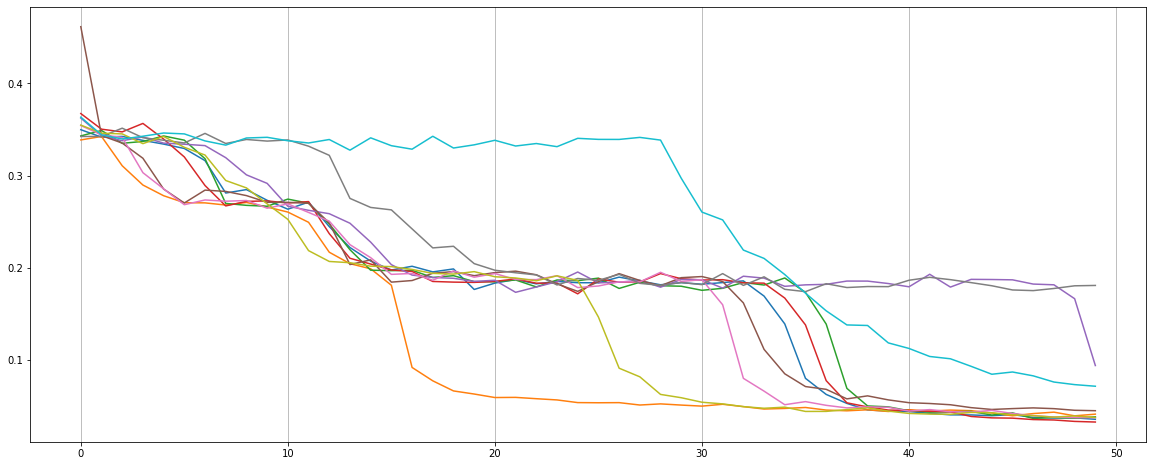

In [3]:
criterion = torch.nn.MSELoss()

def grow(model):
    model.grow(num_novel=4, eps_novel=eps, eps_split=eps)
    
    with model.direction_grad_only():
        optimizer = torch.optim.RMSprop(model.direction_params(), lr=1e-3, momentum=0.1, alpha=0.9)
        
        for _ in range(1):
            optimizer.zero_grad()
            model.update_grown_weight()
            train_x, train_y = toy_data()
            y = model(train_x)
            loss = criterion(y, train_y)
            
            penalty = 0
            for p in model.direction_params():
                penalty += (p ** 2).sum()
            
            loss.backward()
            penalty.backward()
            optimizer.step()
    
        model.update_grown_weight()
    
    with model.new_grad_only():
        model.zero_grad()
        
        for _ in range(200): # batches
            train_x, train_y = toy_data()
            y = model(train_x)
            loss = criterion(y, train_y)

            loss.backward()

        selected = model.select(num_kept_neurons)

    model.degrow(*selected)

series = experiment_series(model_params, runs=runs, grow=grow, lr=lr)

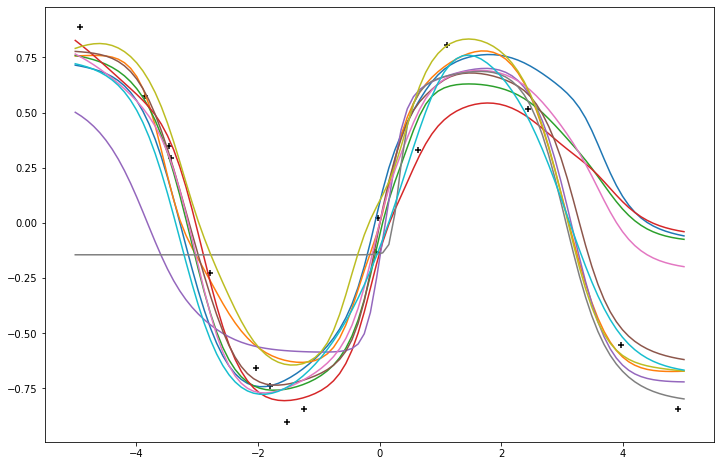

In [4]:
eval_series(series)

In [5]:
d = Path("results")
d.mkdir(parents=True, exist_ok=True)

torch.save(series, d / 'firefly_tuned.pt')